# Simple Combustor

Code is ported (almost) verbatim from the cantera example file `combustor.py` (distributed with cantera):
```
"""
A combustor. Two separate stream - one pure methane and the other air, both at
300 K and 1 atm flow into an adiabatic combustor where they mix and burn.

We are interested in the steady-state burning solution. Since at 300 K no
reaction will occur between methane and air, we need to use an 'igniter' to
initiate the chemistry. A simple igniter is a pulsed flow of atomic hydrogen.
After the igniter is turned off, the system approaches the steady burning
solution.
"""
```

In [1]:
import math
import cantera as ct

import matplotlib.pyplot as plt
%matplotlib notebook

### Problem Setup

In [2]:
# use reaction mechanism GRI-Mech 3.0
gas = ct.Solution('gri30.xml')

# create a reservoir for the fuel inlet, and set to pure methane.
gas.TPX = 300.0, ct.one_atm, 'CH4:1.0'
fuel_in = ct.Reservoir(gas)
fuel_mw = gas.mean_molecular_weight

# use predefined function Air() for the air inlet
air = ct.Solution('air.xml')
air_in = ct.Reservoir(air)
air_mw = air.mean_molecular_weight

# to ignite the fuel/air mixture, we'll introduce a pulse of radicals. The
# steady-state behavior is independent of how we do this, so we'll just use a
# stream of pure atomic hydrogen.
gas.TPX = 300.0, ct.one_atm, 'H:1.0'
igniter = ct.Reservoir(gas)

# create the combustor, and fill it in initially with N2
gas.TPX = 300.0, ct.one_atm, 'N2:1.0'
combustor = ct.IdealGasReactor(gas)
combustor.volume = 1.0

# create a reservoir for the exhaust
exhaust = ct.Reservoir(gas)

# lean combustion, phi = 0.5
equiv_ratio = 0.5

# compute fuel and air mass flow rates
factor = 0.1
air_mdot = factor * 9.52 * air_mw
fuel_mdot = factor * equiv_ratio * fuel_mw

# create and install the mass flow controllers. Controllers m1 and m2 provide
# constant mass flow rates, and m3 provides a short Gaussian pulse only to
# ignite the mixture
m1 = ct.MassFlowController(fuel_in, combustor, mdot=fuel_mdot)

# note that this connects two reactors with different reaction mechanisms and
# different numbers of species. Downstream and upstream species are matched by
# name.
m2 = ct.MassFlowController(air_in, combustor, mdot=air_mdot)

# The igniter will use a Gaussian time-dependent mass flow rate.
fwhm = 0.2
amplitude = 0.1
t0 = 1.0
igniter_mdot = lambda t: amplitude * math.exp(-(t-t0)**2 * 4 * math.log(2) / fwhm**2)
m3 = ct.MassFlowController(igniter, combustor, mdot=igniter_mdot)

# put a valve on the exhaust line to regulate the pressure
v = ct.Valve(combustor, exhaust, K=1.0)

# the simulation only contains one reactor
sim = ct.ReactorNet([combustor])

### Time Integration

In [3]:
# take single steps to 6 s, writing the results to a CSV file for later
# plotting.
tfinal = 6.0
tnow = 0.0
Tprev = combustor.T
tprev = tnow
states = ct.SolutionArray(gas, extra=['t','tres'])

while tnow < tfinal:
    tnow = sim.step()
    tres = combustor.mass/v.mdot(tnow)
    Tnow = combustor.T
    if abs(Tnow - Tprev) > 1.0 or tnow-tprev > 2e-2:
        tprev = tnow
        Tprev = Tnow
        states.append(gas.state, t=tnow, tres=tres)

#states.write_csv('combustor.csv', cols=('t','T','tres','X'))

### Results

<IPython.core.display.Javascript object>


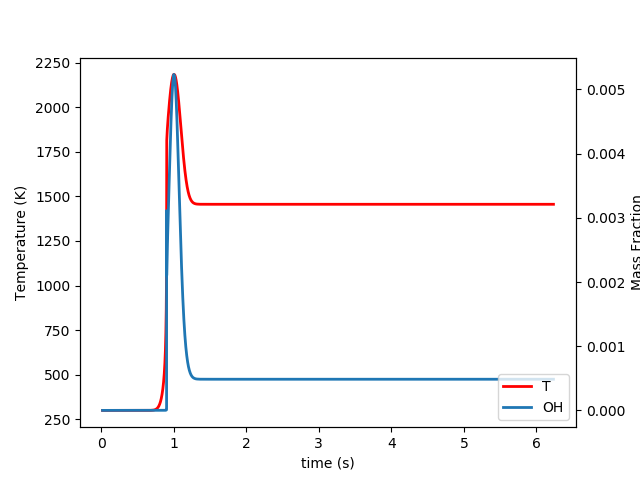

In [4]:
L1 = plt.plot(states.t, states.T, color='r', label='T', lw=2)
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')
plt.twinx()
L2 = plt.plot(states.t, states('OH').Y, label='OH', lw=2)
plt.ylabel('Mass Fraction')
_ = plt.legend(L1+L2, [line.get_label() for line in L1+L2], loc='lower right')    